## Read the data

In [1]:
# import libraries
import pandas as pd
import numpy as np
import re
import datetime
from dateutil.relativedelta import relativedelta
import math
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import seaborn as sns 

In [2]:
covid = pd.read_excel('data/covid_enriched.xlsx')
covid['data_set'] = 'covid'
random = pd.read_excel('data/random_enriched.xlsx')
random['data_set'] = 'random'
fiveG = pd.read_excel('data/5G_enriched.xlsx')
fiveG['data_set'] = '5G'
df = pd.concat([covid, random, fiveG])
df['id_str'] = df['id_str'].astype(str)
print("initial df size: " + str(len(df)))
df = df[df['created_at'].isnull() == False]
print("size after removing null values: " + str(len(df)))
df = df[df['status_lang'] == 'en']
print("size after removing non-english accounts: " + str(len(df)))
df = df.reset_index(drop=True)

initial df size: 28685
size after removing null values: 28684
size after removing non-english accounts: 18264


## Select accounts that are more likely to be non-automated and combine with Bot-wiki accounts

In [3]:
pd.set_option('mode.chained_assignment', None)
human_accounts = df[df['cap_en'] <= 0.5]
human_accounts.loc[:,'bot'] = False
print("Count of Accounts with CAP <= 0.5: " + str(len(human_accounts)))

Count of Accounts with CAP <= 0.5: 7120


In [4]:
bots = pd.read_excel('data/bot_wiki_enriched_accounts.xlsx')
bots.loc[:,'bot'] = True
print("Count of Bot-wiki Accounts: " + str(len(bots)))

Count of Bot-wiki Accounts: 65


In [5]:
df = pd.concat([human_accounts, bots])
len(df)

7185

## Format data

In [6]:
df['created_at'] = df['created_at'].apply(lambda x: datetime.datetime.strptime(str(x), '%a %b %d %H:%M:%S +0000 %Y'))
df['status_created_at'] = df['status_created_at'].apply(lambda x: datetime.datetime.strptime(str(x), '%a %b %d %H:%M:%S +0000 %Y'))

## Generate additional features

In [7]:
# calculate account age
df['user_age'] = df.apply(lambda x: x['status_created_at'] - x['created_at'], axis=1)
df['user_age'] = df['user_age'].apply(lambda x: x.days + 1)

# calculate growth rates
df['tweet_freq'] = df.apply(lambda x: x['statuses_count']/x['user_age'], axis=1)
df['followers_growth_rate'] = df.apply(lambda x: x['followers_count']/x['user_age'], axis=1)
df['friends_growth_rate'] = df.apply(lambda x: x['friends_count']/x['user_age'], axis=1)
df['favourites_growth_rate'] = df.apply(lambda x: x['favourites_count']/x['user_age'], axis=1)
df['listed_growth_rate'] = df.apply(lambda x: x['listed_count']/x['user_age'], axis=1)

# calculate ratios
def divide(a, b):
    if b == 0:
        return np.nan
    else: 
        return a/b   
df['follower_friend_ratio'] = df.apply(lambda x: divide(x['followers_count'], x['friends_count']), axis=1)
df['follower_favorites_ratio'] = df.apply(lambda x: divide(x['followers_count'], x['favourites_count']), axis=1)
df['tweet_follower_ratio'] = df.apply(lambda x: divide(x['statuses_count'], x['followers_count']), axis=1)
df = df.replace([np.inf, -np.inf], np.nan)
df["follower_friend_ratio"].fillna("0", inplace = True)
df["follower_favorites_ratio"].fillna("0", inplace = True)
df["tweet_follower_ratio"].fillna("0", inplace = True)
df['follower_friend_ratio'] = df['follower_friend_ratio'].astype(float)
df['follower_friend_ratio'] = df['follower_friend_ratio'].round(10)
df['follower_favorites_ratio'] = df['follower_favorites_ratio'].astype(float)
df['follower_favorites_ratio'] = df['follower_favorites_ratio'].round(10)
df['follower_friend_ratio'] = df['follower_friend_ratio'].astype(float)
df['tweet_follower_ratio'] = df['follower_friend_ratio'].round(10)

# calculate name length features
df['name_length'] = df['name'].apply(lambda x: len(str(x)))
df['description_length'] = df['description'].apply(lambda x: len(str(x)))
df['screen_name_length'] = df['screen_name'].apply(lambda x: len(str(x)))
df["screen_name_length"].fillna("0", inplace = True)
df['num_digits_in_screen_name'] = df['screen_name'].apply(lambda x: len(re.findall("[0-9]", x)))
df['num_digits_in_name'] = df['name'].apply(lambda x: len(re.findall("[0-9]", str(x))))

# calculate number of digits at the end of a name
def count_digits_at_end_name(screen_name):
    screen_name_length = len(screen_name)
    midpoint = int(screen_name_length/2)
    end_of_name = screen_name[midpoint:screen_name_length]    
    count = len(re.findall("[0-9]", end_of_name))
    return count
df['num_digits_end_screen_name'] = df['screen_name'].apply(lambda x: count_digits_at_end_name(x))
                
                
# calculate screen name entropy
def character_freq_distribution(screen_names):
    
    def split(word): 
        return [char for char in word]  

    #split characters and combine into one column
    characters = []
    for name in screen_names:
        characters = characters + split(name)
    characters = pd.DataFrame({'value': characters})

    #calculate character counts and frequency
    char_freq = characters['value'].value_counts().reset_index()
    char_freq.columns = ['character', 'count']
    char_freq['freq'] = char_freq['count'].apply(lambda x: x/len(characters))
    return char_freq

def calc_screen_name_likelihood(screen_name, char_freq):
    probabilities = char_freq['freq'][char_freq['character'].isin([char for char in screen_name])]
    entropy = sum([-prob*math.log2(prob) for prob in probabilities])
    return entropy 

screen_names = df['screen_name'].tolist()
char_freq = character_freq_distribution(screen_names)
df['screen_name_likelihood'] = df['screen_name'].apply(lambda x: calc_screen_name_likelihood(x, char_freq))

In [8]:
df.columns

Index(['Unnamed: 0', 'id_str', 'screen_name', 'name', 'location', 'url',
       'description', 'protected', 'verified', 'followers_count',
       'friends_count', 'listed_count', 'favourites_count', 'statuses_count',
       'created_at', 'utc_offset', 'time_zone', 'geo_enabled', 'lang',
       'contributors_enabled', 'is_translator', 'status_text', 'status_source',
       'lat', 'lon', 'status_possibly_sensitive', 'status_isretweet',
       'status_isquote', 'status_lang', 'status_id', 'status_created_at',
       'status_retweet_count', 'status_favorite_count', 'retweet_status_id',
       'reply_to_user_id', 'reply_to_status_id', 'has_default_profile',
       'cap_en', 'cap_un', 'astroturf_raw_en', 'fake_follower_raw_en',
       'financial_raw_en', 'other_raw_en', 'overall_raw_en',
       'self_declared_raw_en', 'spammer_raw_en', 'astroturf_display_en',
       'fake_follower_display_en', 'financial_display_en', 'other_display_en',
       'overall_display_en', 'self_declared_display_en'

## Filter to features and response

In [9]:
user_metadata_cols = ['statuses_count', 'followers_count', 'friends_count',
                      'favourites_count', 'listed_count', 'has_default_profile',
                      'verified']
derived_features = ['tweet_freq', 'followers_growth_rate', 'friends_growth_rate',
                    'favourites_growth_rate', 'listed_growth_rate', 
                    'follower_friend_ratio', 'follower_favorites_ratio', 'tweet_follower_ratio', 
                    'screen_name_length', 'num_digits_in_screen_name',
                    'name_length', 'num_digits_in_name', 'num_digits_end_screen_name',
                    'description_length', 'screen_name_likelihood']
response = ['bot']
botometer_scores = ['cap_en', 'bot_lite', 
                    'astroturf_raw_en', 'fake_follower_raw_en',
                    'financial_raw_en', 'other_raw_en', 
                    'self_declared_raw_en', 'spammer_raw_en']
df = df[user_metadata_cols + derived_features + response + botometer_scores]
df.to_excel("data/processed_data.xlsx")

## Generate diagnostic plots to compare distributions for human and bot accounts

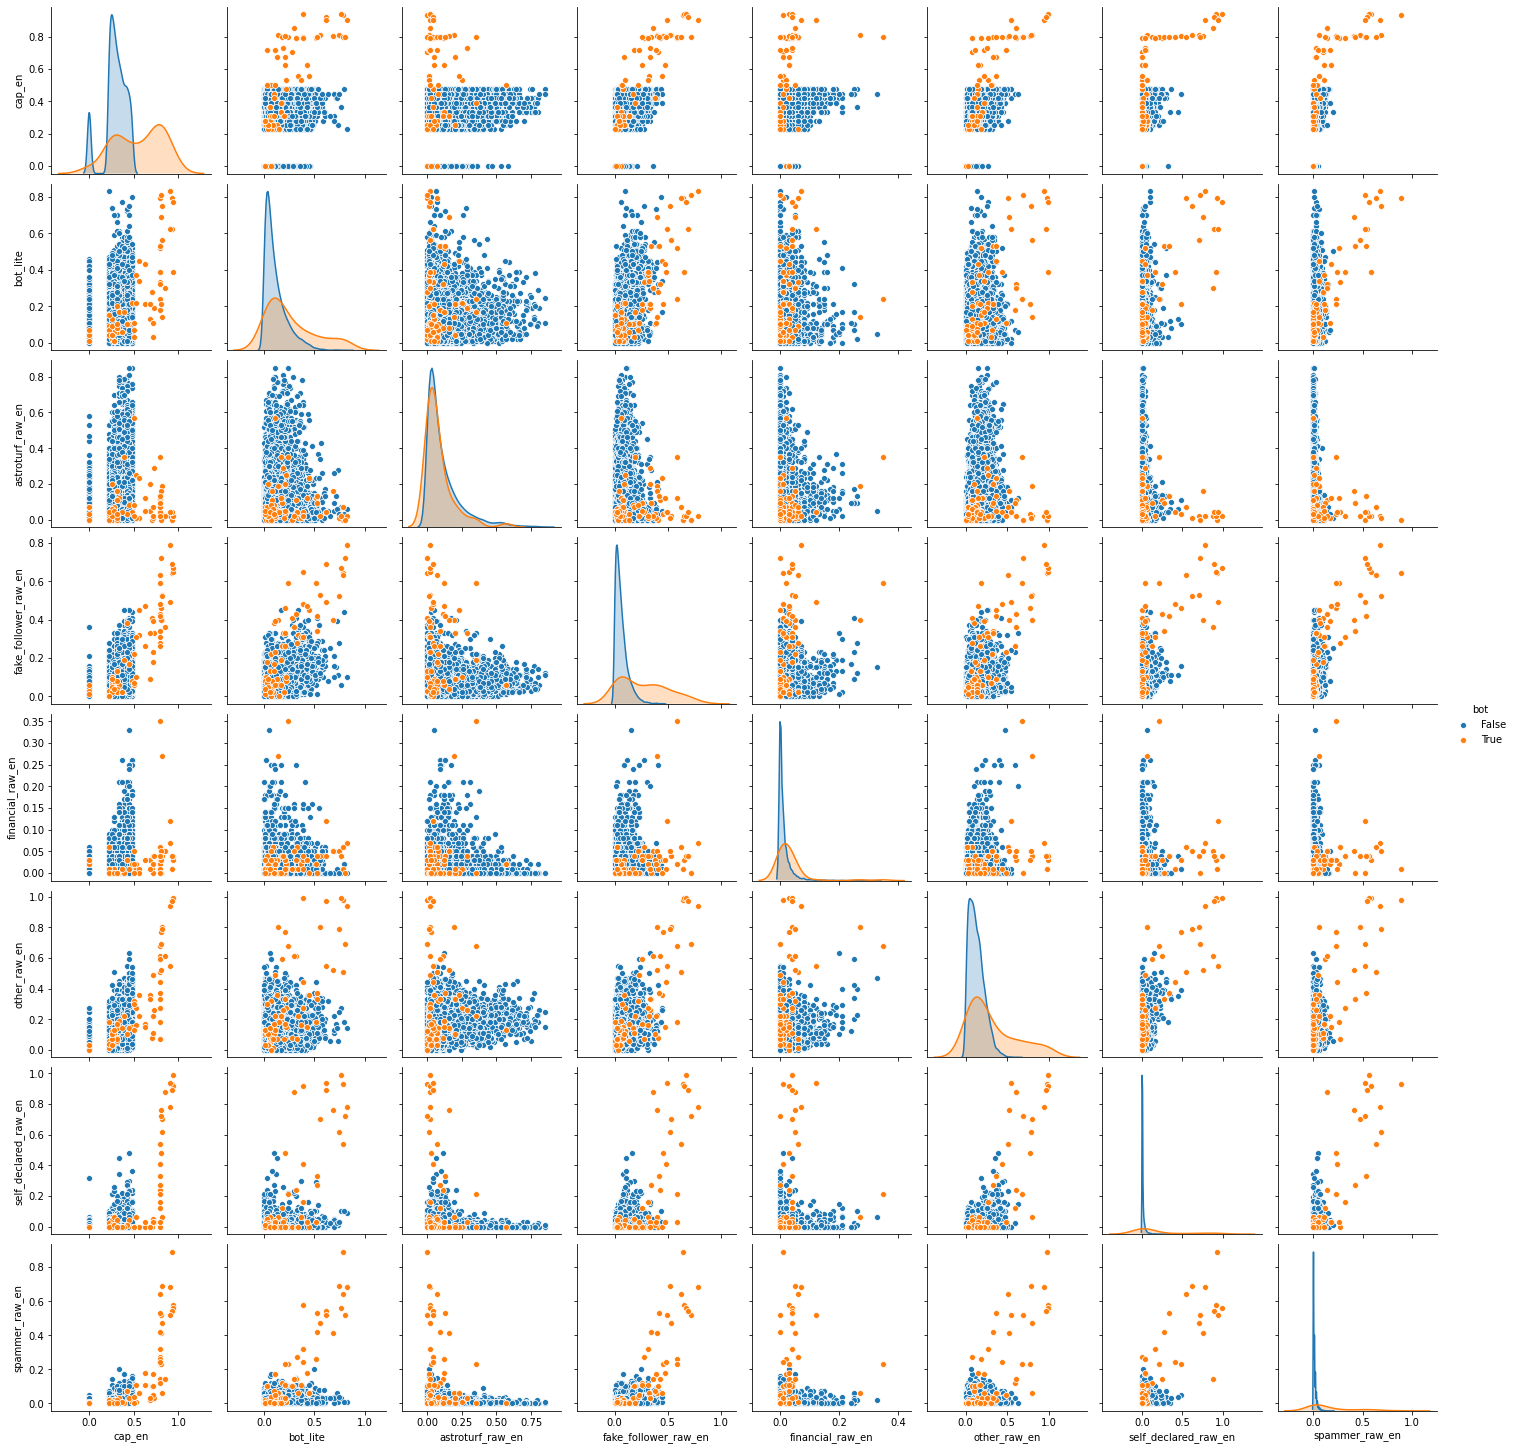

In [10]:
sns.pairplot(df[botometer_scores + ['bot']], hue = 'bot')

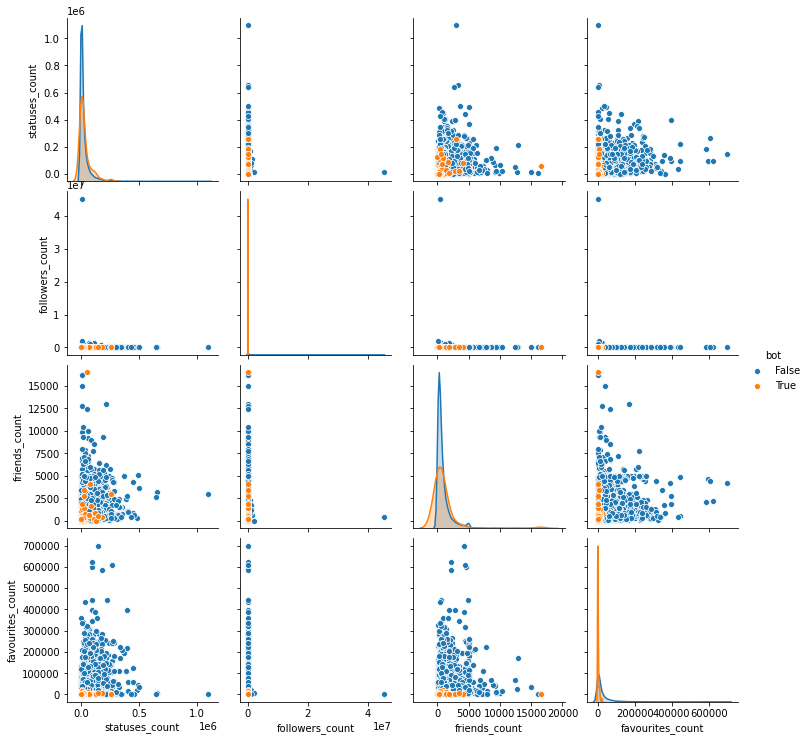

In [11]:
sns.pairplot(df[['statuses_count', 'followers_count', 'friends_count', 'favourites_count', 'bot']], hue = 'bot')

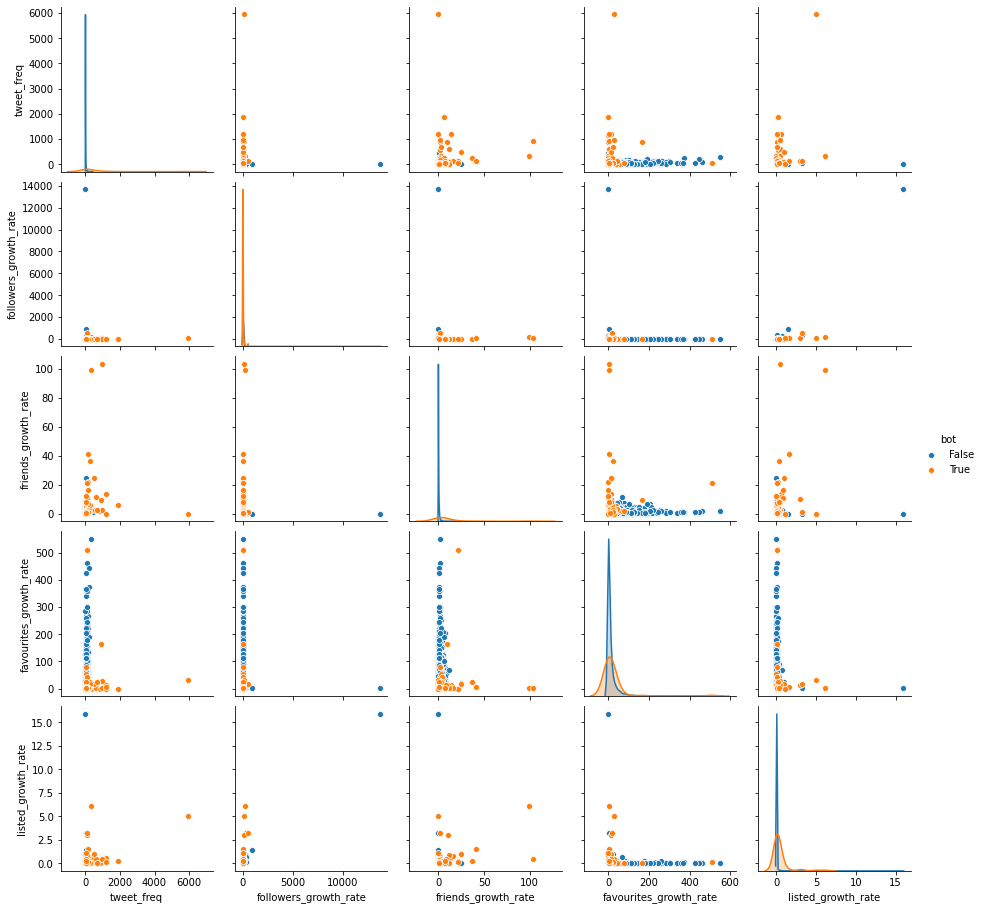

In [12]:
sns.pairplot(df[['tweet_freq', 'followers_growth_rate', 'friends_growth_rate', 
                 'favourites_growth_rate', 'listed_growth_rate', 'bot']], hue = 'bot')